In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import time
from scipy.signal import find_peaks
from scipy.stats import gamma
import statsmodels.api as sm
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping #if delta(difference between actual and predictin) is not reducing
from sklearn.metrics import r2_score
from tensorflow.keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
train = pd.read_csv("/gdrive/MyDrive/NN/Time series/train_ML_IOT.csv")

In [4]:
print(train)

                  DateTime  Junction  Vehicles           ID
0      2015-11-01 00:00:00         1        15  20151101001
1      2015-11-01 01:00:00         1        13  20151101011
2      2015-11-01 02:00:00         1        10  20151101021
3      2015-11-01 03:00:00         1         7  20151101031
4      2015-11-01 04:00:00         1         9  20151101041
...                    ...       ...       ...          ...
48115  2017-06-30 19:00:00         4        11  20170630194
48116  2017-06-30 20:00:00         4        30  20170630204
48117  2017-06-30 21:00:00         4        16  20170630214
48118  2017-06-30 22:00:00         4        22  20170630224
48119  2017-06-30 23:00:00         4        12  20170630234

[48120 rows x 4 columns]


In [5]:
test = pd.read_csv("/gdrive/MyDrive/NN/Time series/test_ML_IOT.csv")

**Preprocessing: **Creating parameters to train

In [6]:
train['DateTime'] = pd.to_datetime(train['DateTime'])
train['Weekday'] = [datetime.weekday(date) for date in train.DateTime]
train['Year'] = [date.year for date in train.DateTime]
train['Month'] = [date.month for date in train.DateTime]
train['Day'] = [date.day for date in train.DateTime]
train['Hour'] = [date.hour for date in train.DateTime]
train['Week'] = [date.week for date in train.DateTime]
train['Quarter'] = [date.quarter for date in train.DateTime]
train["IsWeekend"] = train["Weekday"] >= 5

In [7]:
print(train)

                 DateTime  Junction  Vehicles           ID  Weekday  Year  \
0     2015-11-01 00:00:00         1        15  20151101001        6  2015   
1     2015-11-01 01:00:00         1        13  20151101011        6  2015   
2     2015-11-01 02:00:00         1        10  20151101021        6  2015   
3     2015-11-01 03:00:00         1         7  20151101031        6  2015   
4     2015-11-01 04:00:00         1         9  20151101041        6  2015   
...                   ...       ...       ...          ...      ...   ...   
48115 2017-06-30 19:00:00         4        11  20170630194        4  2017   
48116 2017-06-30 20:00:00         4        30  20170630204        4  2017   
48117 2017-06-30 21:00:00         4        16  20170630214        4  2017   
48118 2017-06-30 22:00:00         4        22  20170630224        4  2017   
48119 2017-06-30 23:00:00         4        12  20170630234        4  2017   

       Month  Day  Hour  Week  Quarter  IsWeekend  
0         11    1     0

Junction(any input) is independent variable and vehicles(any prediction) are dependent variable

In [8]:
j1=train[train["Junction"]==1]
j2=train[train["Junction"]==2]
j3=train[train["Junction"]==3]
j4=train[train["Junction"]==4]

js = [j1, j2, j3, j4]

In [9]:
print(train[train["Junction"]==1])

                 DateTime  Junction  Vehicles           ID  Weekday  Year  \
0     2015-11-01 00:00:00         1        15  20151101001        6  2015   
1     2015-11-01 01:00:00         1        13  20151101011        6  2015   
2     2015-11-01 02:00:00         1        10  20151101021        6  2015   
3     2015-11-01 03:00:00         1         7  20151101031        6  2015   
4     2015-11-01 04:00:00         1         9  20151101041        6  2015   
...                   ...       ...       ...          ...      ...   ...   
14587 2017-06-30 19:00:00         1       105  20170630191        4  2017   
14588 2017-06-30 20:00:00         1        96  20170630201        4  2017   
14589 2017-06-30 21:00:00         1        90  20170630211        4  2017   
14590 2017-06-30 22:00:00         1        84  20170630221        4  2017   
14591 2017-06-30 23:00:00         1        78  20170630231        4  2017   

       Month  Day  Hour  Week  Quarter  IsWeekend  
0         11    1     0

Detecting outliers using normal distribution

In [10]:
def outlier_detection(j, std_param = 3, window_length = 720, alpha = 0.04):
    
    rmeans = j.rolling(window_length, min_periods=1).median()
    rstd = j.rolling(window_length, min_periods=1).std()
    rstd_lower = j[j<rmeans].rolling(window_length ,min_periods=1).std()
    
    kurt = j.kurt() #to normalize  std_param = 3
    
    upper = rmeans+std_param*rstd*np.exp(alpha*kurt)
    lower = rmeans - (5*rstd_lower)    #??
    idx1 = (j>upper)
    idx2 = (j<lower)
    
    idx = idx1 | idx2 #| = bitwise or
    
    return j, idx, rmeans, upper, lower

In [11]:
jads = [j1, j2, j3, j4]
for i,j in enumerate(js): #
    jads[i] = j.Vehicles
    jads[i].index = j.DateTime

In [12]:
  print(jads)

[DateTime
2015-11-01 00:00:00     15
2015-11-01 01:00:00     13
2015-11-01 02:00:00     10
2015-11-01 03:00:00      7
2015-11-01 04:00:00      9
                      ... 
2017-06-30 19:00:00    105
2017-06-30 20:00:00     96
2017-06-30 21:00:00     90
2017-06-30 22:00:00     84
2017-06-30 23:00:00     78
Name: Vehicles, Length: 14592, dtype: int64, DateTime
2015-11-01 00:00:00     6
2015-11-01 01:00:00     6
2015-11-01 02:00:00     5
2015-11-01 03:00:00     6
2015-11-01 04:00:00     7
                       ..
2017-06-30 19:00:00    34
2017-06-30 20:00:00    35
2017-06-30 21:00:00    31
2017-06-30 22:00:00    29
2017-06-30 23:00:00    27
Name: Vehicles, Length: 14592, dtype: int64, DateTime
2015-11-01 00:00:00     9
2015-11-01 01:00:00     7
2015-11-01 02:00:00     5
2015-11-01 03:00:00     1
2015-11-01 04:00:00     2
                       ..
2017-06-30 19:00:00    33
2017-06-30 20:00:00    31
2017-06-30 21:00:00    28
2017-06-30 22:00:00    26
2017-06-30 23:00:00    39
Name: Vehicle

Deleting outliers 

---



In [13]:
for j in jads:
    j, idx, rmeans, upper, lower = outlier_detection(j)
    j[idx] = np.nan #adds null value to outliers to delete them

<ipython-input-13-84645531f95e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j[idx] = np.nan #adds null value to outliers to delete them
<ipython-input-13-84645531f95e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j[idx] = np.nan #adds null value to outliers to delete them
<ipython-input-13-84645531f95e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j[idx] = np.nan #adds null value to outliers to delete them
<ipython-input-1

Filling vacant spaces https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ffill.html

In [14]:
j1 = j1.interpolate(method="ffill")
j2 = j2.interpolate(method="ffill")
j3 = j3.interpolate(method="ffill")
j4 = j4.interpolate(method="ffill")

Converts data frame(like csv file[link text](https://)) to array: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

```
# This is formatted as code
```



In [15]:

j1 = j1.Vehicles.to_numpy()
j2 = j2.Vehicles.to_numpy()
j3 = j3.Vehicles.to_numpy()
j4 = j4.Vehicles.to_numpy()

Selecting some values from the data set

In [16]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [17]:
js = [j1, j2, j3, j4]

In [18]:
def data_prep(j, look_back):
    train_size = int(len(j) * 0.85) #85% is trained and 15% is tested = validation
    test_size = len(j) - train_size #15%
    j_train, j_test = j[0:train_size], j[train_size:len(j)] # assigning test and train

    # print("Assigning train and test")
    print(type(j))
    print(type(j_train))
    print(type(j_test))

    j_train = j_train.reshape(-1,1) # reshape = size(numpy) is converted to 1D then placed in columns (from rows)
    j_test = j_test.reshape(-1,1)

    # print("Reshape train and test")
    # print(j_train)
    # print(j_test)

    scaler = StandardScaler()
    scaler.fit(j_train)

    j_train = scaler.transform(j_train)
    j_test= scaler.transform(j_test)

    # print("Scaler train and test")
    # print(j_train)
    # print(j_test)

    X_train, Y_train = create_dataset(j_train, look_back)
    X_test, Y_test = create_dataset(j_test, look_back)

    # print("create dataset train and test")
    # print(X_train)
    # print(Y_train)

    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    # print("Reshape train and test")
    # print(X_train)
    # print(X_test)
    return X_train, Y_train, X_test, Y_test, scaler

Creating model using lstm: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [19]:


def model(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam') # adam is a technique to optimize NN

    model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), #fits(trains) the data into the model
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False) # shuffle = false: since it is a time series the sequence is kept intact

    #model.summary()
    plot_model(model, to_file='model.png',show_shapes=True)
    train_predict = model.predict(X_train) #model prediction = gives output
    test_predict = model.predict(X_test)
    
    return train_predict, test_predict

In [20]:
# def model(X_train, Y_train, X_test, Y_test):
#     model = Sequential()
#     model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(Dropout(0.2))
#     model.add(Dense(1))
#     model.compile(loss='mean_squared_error', optimizer='adam')

#     model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), 
#                     callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)

#     #model.summary()
    
#     train_predict = model.predict(X_train)
#     test_predict = model.predict(X_test)
    
#     return train_predict, test_predict

In [21]:
look_back = [12,24,48,72,168] #look back period

In [22]:
for k, m in enumerate(look_back):
    print("look back = ", str(look_back[k]))

look back =  12
look back =  24
look back =  48
look back =  72
look back =  168


In [23]:
for j in js:
  print(type(j))
  print(j)
  break

<class 'numpy.ndarray'>
[15. 13. 10. ... 90. 84. 78.]


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
68/68 [==============================] - 0s 2ms/step


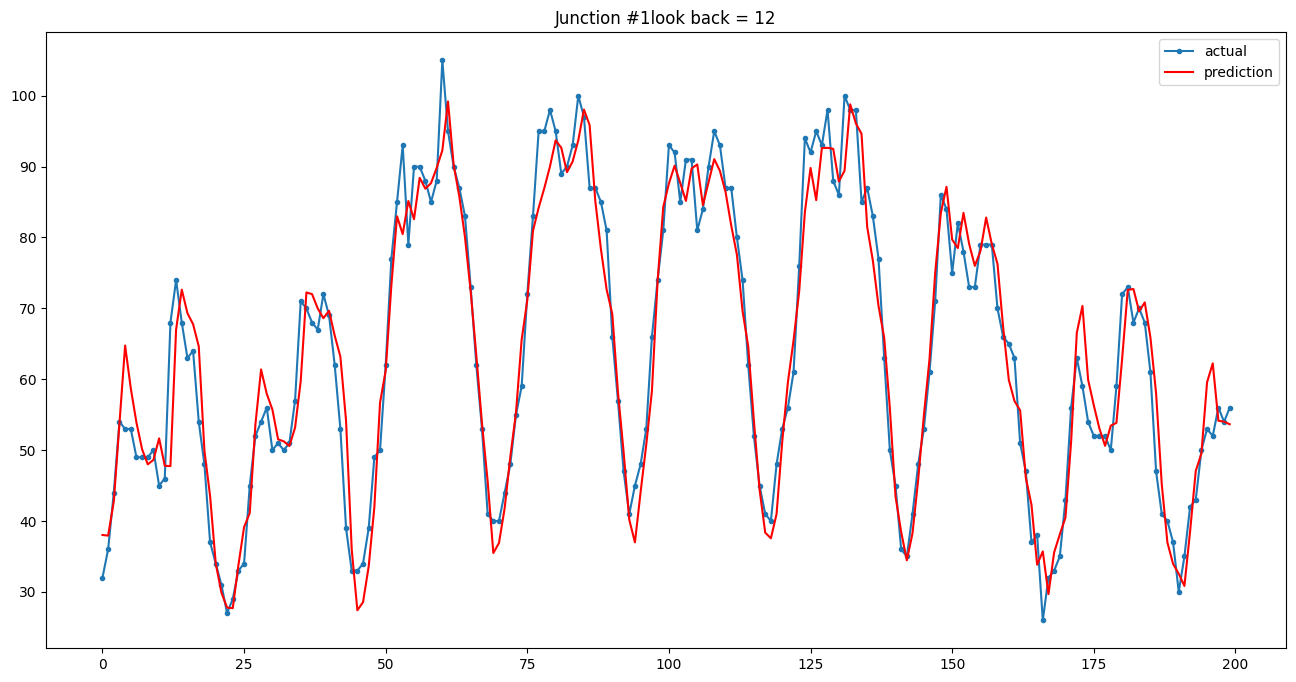

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
68/68 [==============================] - 0s 2ms/step


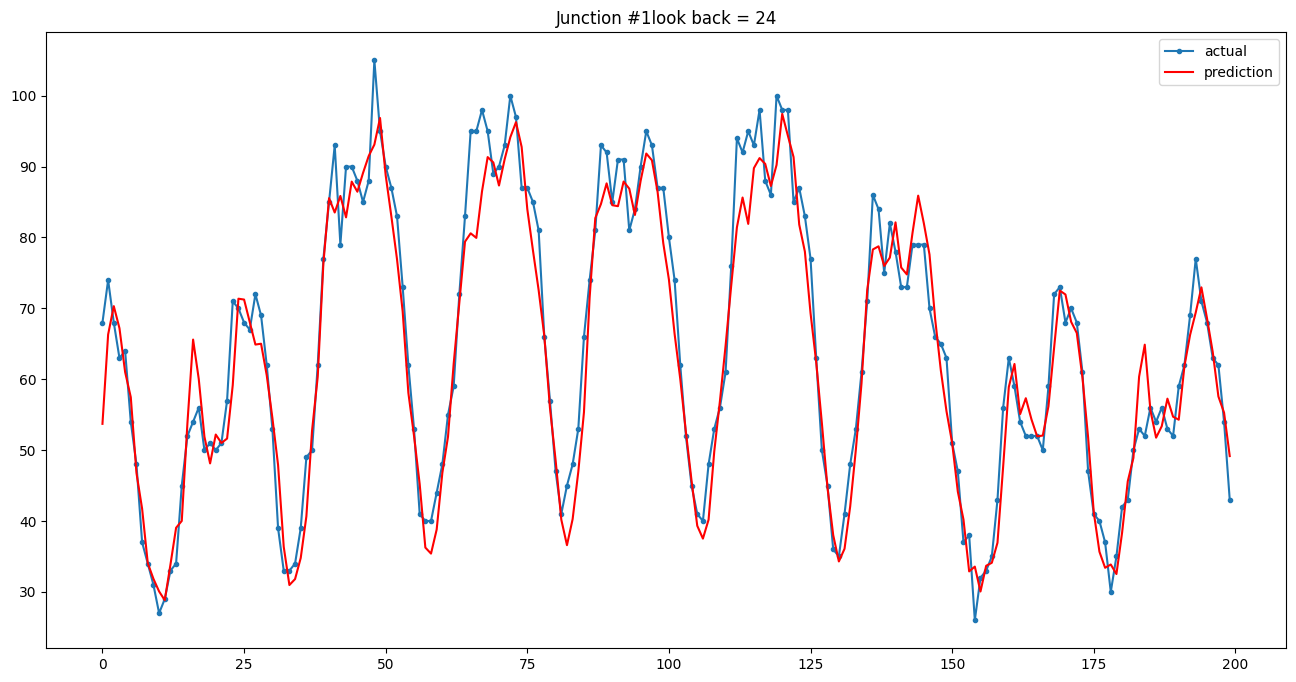

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
67/67 [==============================] - 0s 3ms/step


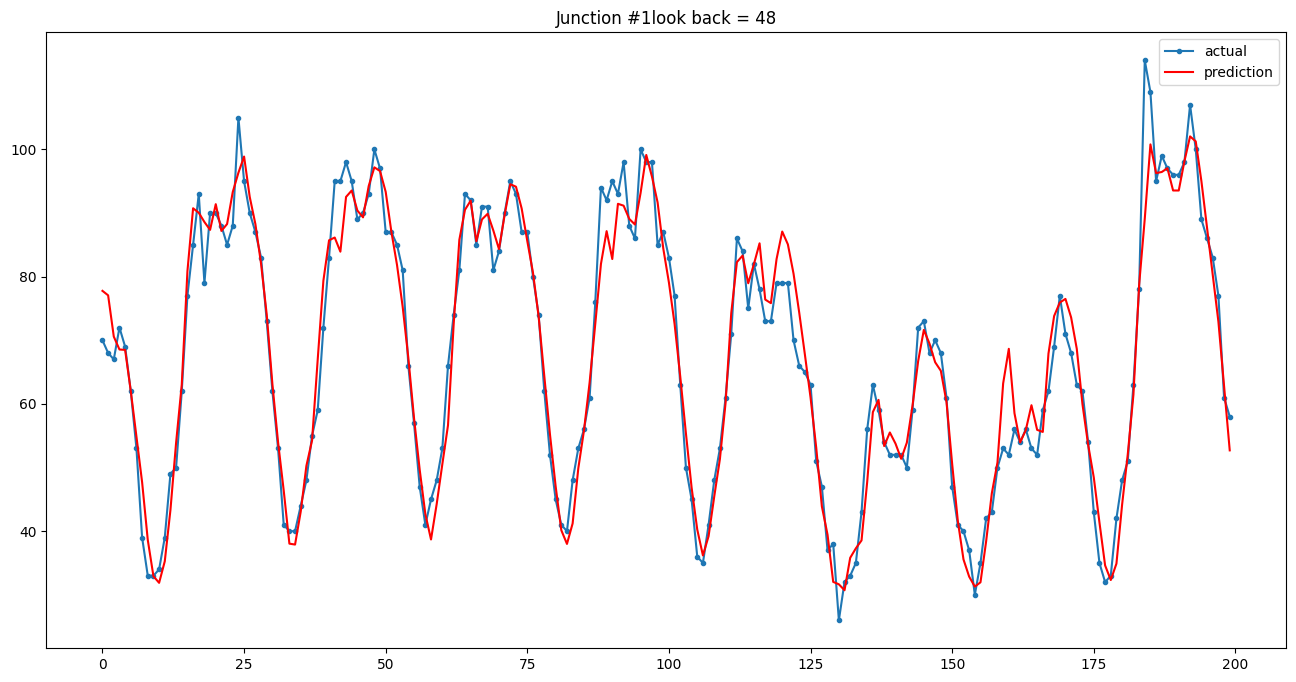

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
67/67 [==============================] - 0s 2ms/step


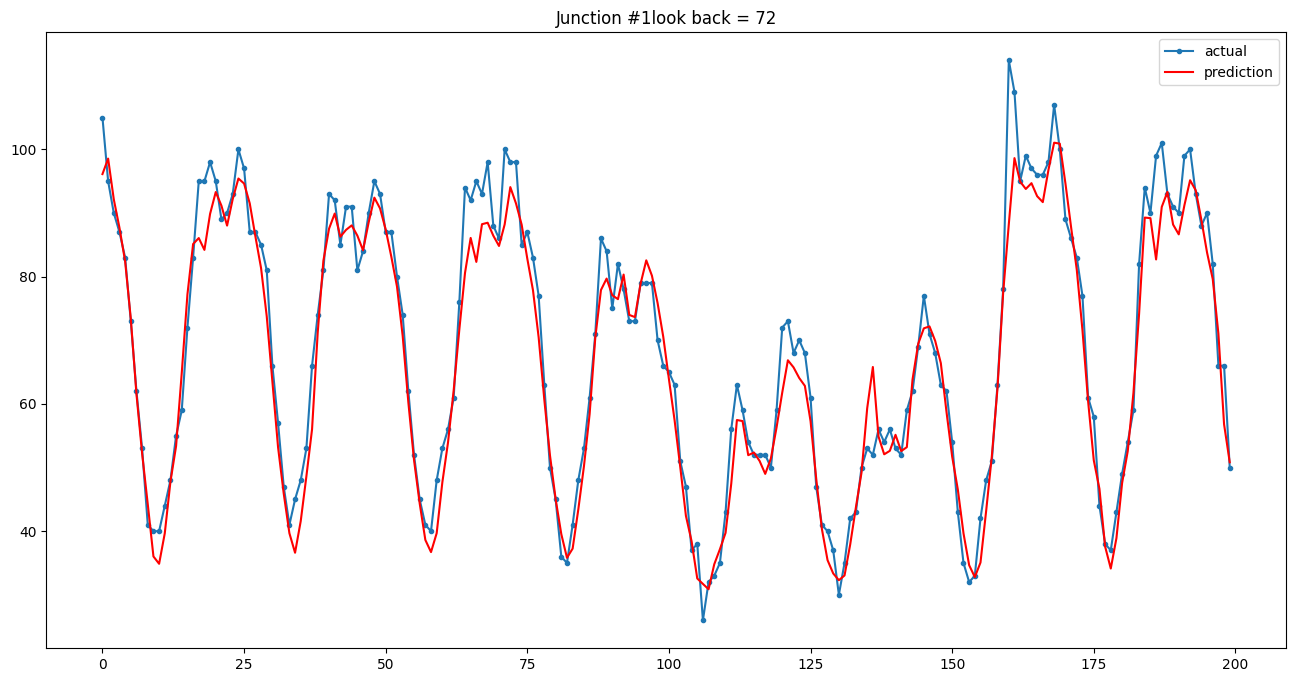

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
mae_mat = np.zeros((len(js),len(look_back))) #matrix calculation mae= mean absolute error
mape_mat = np.zeros((len(js),len(look_back))) # mape = mean absolute percentage error
r2_mat = np.zeros((len(js),len(look_back))) #r2 score

for i,j in enumerate(js):
    for k, m in enumerate(look_back):
        X_train, Y_train, X_test, Y_test, scaler = data_prep(j,m)
        # break
        train_predict, test_predict = model(X_train, Y_train, X_test, Y_test)

        train_predict = scaler.inverse_transform(train_predict)
        Y_train = scaler.inverse_transform([Y_train])
        test_predict = scaler.inverse_transform(test_predict)
        Y_test = scaler.inverse_transform([Y_test])

        mae_mat[i][k] = mean_absolute_error(Y_test[0], test_predict[:,0])
        mape_mat[i][k] = np.mean(np.abs(Y_test[0] - test_predict[:,0])/(Y_test[0]))*100
        r2_mat[i][k] = r2_score(Y_test[0],test_predict[:,0])
    
    
        plt.figure(figsize=(16,8))
        plt.plot(Y_test[0][:200], marker='.', label="actual")
        plt.plot(test_predict[:,0][:200], 'r', label="prediction")
        plt.title('Junction #' + str(i+1) + "look back = " + str(look_back[k]))
        plt.legend()
        plt.show()
    #break

In [ ]:
fig, axs = plt.subplots(3, 1,figsize=(10,10))
axs[0].axis("off")
axs[0].title.set_text('Mean Absolute Error')
the_table = axs[0].table(cellText=mae_mat, loc='center right',
                         rowLabels=[" 1 "," 2 "," 3 "," 4 "],colLabels=look_back)
#the_table.scale(2, 2)

axs[1].axis("off")
axs[1].title.set_text('Mean Absolute Percentage Error')
the_table = axs[1].table(cellText=mape_mat, loc='center right',
                         rowLabels=[" 1 "," 2 "," 3 "," 4 "],colLabels=look_back)
#the_table.scale(2, 2)

axs[2].axis("off")
axs[2].title.set_text('R2 score')
the_table = axs[2].table(cellText=r2_mat, loc='center right',
                         rowLabels=[" 1 "," 2 "," 3 "," 4 "],colLabels=look_back)
#the_table.scale(2, 2)

plt.show()